# Homework

1) Изучить соревнование, просмотреть все данные

2) Провалидировать и засабмитить следующие модели в виде классов с `fit/recommend`:
- popular
- popular covered by n% of unique users
- PopularInCategoryModel на user features
- PopularInCategoryModel на item features

2.1) За дополнительную оценку можно реализовать что-то из списка (в простом виде):
  - SLIM
  - Frequent pattern mining
  - Markov chains
  
3) Итоговый список артефактов в репозитории:
- описание virtualenv
- скрипты или ipynb с обучением моделей и подбором гиперпараметров
- визуализация результатов оффлайн валидации
- сравнение некоторых результатов оффлайн владиации с итоговым скором на лидерборде

In [1]:
# turn off bad autocompleter
%config Completer.use_jedi = False
# magic for modules reloading 
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm.auto import tqdm
# from scipy.stats import mode
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import gc
# import warnings
# warnings.filterwarnings("ignore")

from rectools import Columns
from rectools.dataset import Dataset, Interactions

# Load data

In [3]:
interactions = pd.read_csv('data_full/interactions.csv')
users = pd.read_csv('data_full/users.csv')
items = pd.read_csv('data_full/items.csv')

## Interactions

In [4]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [5]:
interactions = interactions.rename(columns = {
    'last_watch_dt': Columns.Datetime,
    'total_dur': Columns.Weight,
})

In [6]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   datetime     object 
 3   weight       int64  
 4   watched_pct  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.9+ MB


In [7]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [8]:
interactions.duplicated().sum()

0

## Users

In [9]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [10]:
users.duplicated().sum()

0

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [12]:
list(users.age.unique())

['age_25_34',
 'age_18_24',
 'age_45_54',
 'age_35_44',
 nan,
 'age_55_64',
 'age_65_inf']

In [13]:
list(users.income.unique())

['income_60_90',
 'income_20_40',
 'income_40_60',
 'income_0_20',
 nan,
 'income_90_150',
 'income_150_inf']

In [15]:
list(users.sex.unique())

['М', 'Ж', nan]

In [19]:
users.age.isna().sum()

14095

In [16]:
users.income.isna().sum()

14776

In [17]:
users.sex.isna().sum()

13831

In [18]:
users.kids_flg.isna().sum()

0

In [22]:
(
    users.age.isna()
    | users.income.isna()
    | users.sex.isna()
).sum() / users.shape[0]

0.025605899568791606

In [23]:
order=[
    'income_0_20',
    'income_20_40',
    'income_40_60',
    'income_60_90',
    'income_90_150',
    'income_150_inf',
]

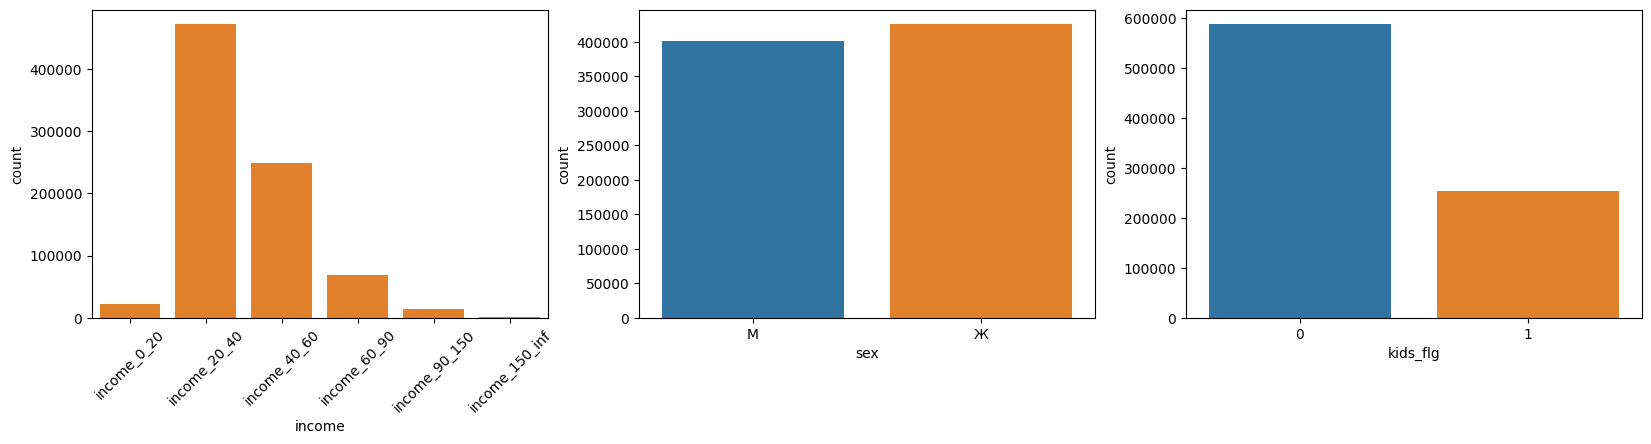

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
sns.countplot(x=users.income, order=order, color='C1', ax=ax[0])
ax[0].set_xticklabels(order, rotation = 45)

sns.countplot(x=users.sex, ax=ax[1])
sns.countplot(x=users.kids_flg, ax=ax[2])
plt.show()

## Items

In [42]:
items.T

,0,1,2,3,4,5,6,7,8,9,...,15953,15954,15955,15956,15957,15958,15959,15960,15961,15962
item_id,10711,2508,10716,7868,16268,854,1468,11114,9853,8604,...,14075,11670,5525,1325,15610,6443,2367,10632,4538,3206
content_type,film,film,film,film,film,film,film,film,film,film,...,series,series,series,series,series,series,series,series,series,series
title,Поговори с ней,Голые перцы,Тактическая сила,45 лет,Все решает мгновение,Северо-Юг,Марья-искусница,Принцесса Лебедь: Пират или принцесса,Лабиринты прошлого,Третья попытка,...,Хочу в ВиаГру,Эд Стаффорд: игра на вылет,Кто из нас не любил,Старое ружьё,Цена любви,Полярный круг,Надежда,Сговор,Среди камней,Гоша
title_orig,Hable con ella,Search Party,Tactical Force,45 Years,NaN,NaN,NaN,"The Swan Princess: Princess Tomorrow, Pirate T...",Todos lo saben,NaN,...,NaN,Ed Stafford: First Man Out,We All Fall in Love,Staroye ruzh'ye,Tsena Lubvi,Arctic Circle,NaN,Hassel,Darklands,NaN
release_year,2002.0,2014.0,2011.0,2015.0,1978.0,2015.0,1960.0,2016.0,2018.0,2013.0,...,2013.0,2018.0,2016.0,2014.0,2015.0,2018.0,2020.0,2017.0,2019.0,2019.0
genres,"драмы, зарубежные, детективы, мелодрамы","зарубежные, приключения, комедии","криминал, зарубежные, триллеры, боевики, комедии","драмы, зарубежные, мелодрамы","драмы, спорт, советские, мелодрамы","драмы, русские","фильмы, сказки, приключения, советские, семейн...","для детей, сказки, полнометражные, зарубежные,...","криминал, детективы, драмы, зарубежные, триллеры","русские, мелодрамы",...,музыкальные,телешоу,драмы,"драмы, военные",мелодрамы,"драмы, триллеры, криминал","драмы, боевики","драмы, триллеры, криминал","драмы, спорт, криминал",комедии
countries,Испания,США,Канада,Великобритания,СССР,Россия,СССР,США,Испания,Россия,...,Украина,Сингапур,Турция,Россия,Россия,"Финляндия, Германия",Россия,Россия,Россия,Россия
for_kids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
age_rating,16.0,16.0,16.0,16.0,12.0,16.0,6.0,6.0,16.0,12.0,...,16.0,16.0,16.0,16.0,16.0,16.0,18.0,18.0,18.0,16.0
studios,NaN,NaN,NaN,NaN,Ленфильм,NaN,NaN,Sony Pictures,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
items.content_type.unique()

array(['film', 'series'], dtype=object)

In [44]:
items.studios.unique()

array([nan, 'Ленфильм', 'Sony Pictures', 'Starz', 'BBC',
       'Ленфильм, рентв', 'HBO', 'Paramount', 'Universal', 'Sky',
       'Cinemax', 'CBS', 'Sony Plus, рентв', 'FX', 'Sky, Fremantle',
       'Warner Bros. Television', 'DAZN', 'Warner Bros', 'Fremantle',
       'Sony Pictures, рентв', 'Fox', 'HBO, BBC', 'Мосфильм', 'Showtime',
       'Endemol', 'Sony Pictures Television', 'CBS All Access', 'ABC',
       'Universal, рентв', 'Amediateka', 'Рок фильм', 'Disney', 'HBO Max',
       'MGM', 'Legendary', 'рентв', 'Channel 4',
       'New Regency Productions', 'Sony Plus'], dtype=object)

In [48]:
items.countries.unique().shape

(688,)

In [51]:
items.countries.str.split(', ').explode().unique().shape

(92,)

In [52]:
items.countries.str.split(', ').explode().unique()

array(['Испания', 'США', 'Канада', 'Великобритания', 'СССР', 'Россия',
       'Иран', 'Германия', 'Италия', 'Аргентина', 'Франция', 'Украина',
       'Япония', 'Швеция', 'Норвегия', 'Чехия', 'Китай', 'Тайвань',
       'Республика Корея', 'Израиль', 'Дания', 'Исландия', 'Бельгия',
       'Казахстан', 'Новая Зеландия', 'Австралия', 'Мексика',
       'Нидерланды', 'Кипр', 'Маврикий', 'Гонконг', 'Ирландия',
       'Болгария', 'Беларусь', 'Киргизия', 'Румыния', nan, 'Мальта',
       'Чили', 'Армения', 'Индия', 'Таиланд', 'Венгрия', 'Сенегал',
       'Бразилия', 'Польша', 'Люксембург', 'Турция', 'ЮАР', 'Швейцария',
       'Македония', 'Финляндия', 'Узбекистан', 'Малайзия', 'ОАЭ',
       'Португалия', 'Филиппины', 'Пуэрто-Рико', 'Перу', 'Латвия',
       'Австрия', 'Алжир', 'Колумбия', 'Венесуэла', 'Уругвай',
       'Индонезия', 'Хорватия', 'Сингапур', 'Камбоджа', 'Парагвай',
       'Сербия', 'Молдова', 'Эстония', 'Албания', 'Югославия', 'Словакия',
       'Словения', 'Эквадор', 'Грузия', 'Еги

In [55]:
items.for_kids.unique()

array([nan,  0.,  1.])

In [57]:
items.age_rating.unique()

array([16., 12.,  6., 18.,  0., 21., nan])

In [ ]:
items.keywords

0        Поговори, ней, 2002, Испания, друзья, любовь, ...
1        Голые, перцы, 2014, США, друзья, свадьбы, прео...
2        Тактическая, сила, 2011, Канада, бандиты, ганг...
3        45, лет, 2015, Великобритания, брак, жизнь, лю...
4        Все, решает, мгновение, 1978, СССР, сильные, ж...
                               ...                        
15958    убийство, вирус, расследование преступления, н...
15959                                Надежда, 2020, Россия
15960                                 Сговор, 2017, Россия
15961                          Среди, камней, 2019, Россия
15962                                   Гоша, 2019, Россия
Name: keywords, Length: 15963, dtype: object

In [70]:
items.directors.unique().shape

(7974,)

In [75]:
items.directors.str.split(', ').explode().unique().shape

(8840,)

In [53]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [46]:
items.duplicated().sum()

0

# Cast features to needed format

In [37]:
def make_feature(data, main_col, feature_col):
    feature = data[[main_col, feature_col]].rename(columns={feature_col: 'value'})
    feature['feature'] = feature_col
    return feature

## User features

In [38]:
age = make_feature(users, 'user_id', 'age')
sex = make_feature(users, 'user_id', 'sex')
has_kids = make_feature(users, 'user_id', 'kids_flg')
income = make_feature(users, 'user_id', 'income')


In [39]:
user_features = pd.concat((age, sex, has_kids, income))

In [40]:
user_features

,user_id,value,feature
0,973171,age_25_34,age
1,962099,age_18_24,age
2,1047345,age_45_54,age
3,721985,age_45_54,age
4,704055,age_35_44,age
...,...,...,...
840192,339025,income_0_20,income
840193,983617,income_20_40,income
840194,251008,NaN,income
840195,590706,NaN,income


In [41]:
user_features = user_features[user_features.user_id.isin(interactions.user_id)]

## Item features

In [59]:
items_cat_columns = [
    'content_type',
    'countries',
    'for_kids',
    'studios',
    'age_rating',
    'for_kids',
    
]

In [60]:
items['genre'] = items.genres.str.split(',')

In [66]:
items['country'] = items.countries.str.split(', ')

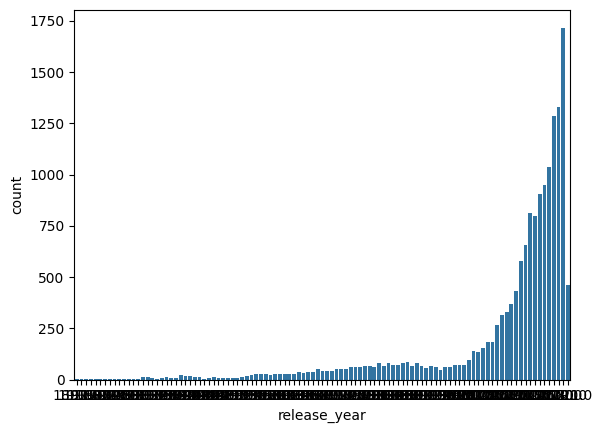

In [61]:
sns.countplot(x=items.release_year.astype(float), color='C0');

In [62]:
_, bins = pd.qcut(items.release_year, 10, retbins=True)

labels = bins[:-1]
year_feature = pd.DataFrame(
    {
        Columns.Item: items[Columns.Item],
        "value": pd.cut(items["release_year"], bins=bins, labels=bins[:-1]),
        "feature": "release_year",
    }
)

In [63]:
year_feature.head()

,item_id,value,feature
0,10711,1983.0,release_year
1,2508,2012.0,release_year
2,10716,2009.0,release_year
3,7868,2014.0,release_year
4,16268,1897.0,release_year


<AxesSubplot: xlabel='value', ylabel='count'>

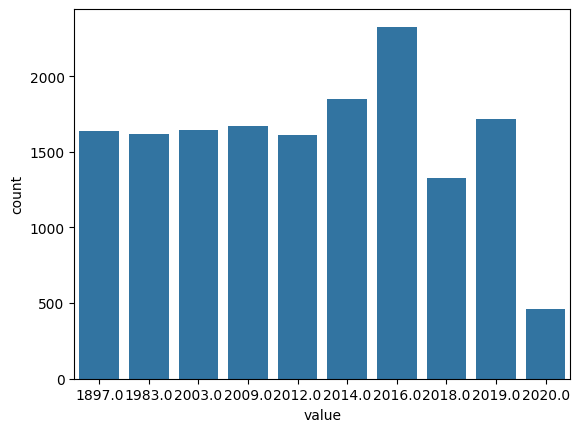

In [64]:
sns.countplot(x=year_feature.value, color='C0')

In [65]:
genre_feature = items[[Columns.Item, "genre"]].explode("genre")
genre_feature.columns = [Columns.Item, "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,item_id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [76]:
country_feature = items[[Columns.Item, 'country']].explode('country')
country_feature.columns = [Columns.Item, 'value']
country_feature['feature'] = 'country'
country_feature.head()

,item_id,value,feature
0,10711,Испания,country
1,2508,США,country
2,10716,Канада,country
3,7868,Великобритания,country
4,16268,СССР,country


In [44]:
item_feat = pd.concat([genre_feature, year_feature])
item_feat = item_feat[item_feat[Columns.Item].isin(interactions[Columns.Item])]

In [45]:
gc.collect()

25264

# Constuct dataset

In [46]:
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=user_features,
    cat_user_features=['sex', 'has_kids'],
    item_features_df=item_feat,
    cat_item_features=['genre', 'release_year']
)

# Validation

In [96]:
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import MAP, Recall, calc_metrics

from rectools.models.popular import PopularModel
from rectools.models.popular_in_category import PopularInCategoryModel

In [97]:
from models import UsersCoverageModel # custom n% coverage model

In [119]:
daily_inters = interactions.groupby(Columns.Datetime)[Columns.User].agg('count')
daily_inters.name = 'interactions'
# daily_inters

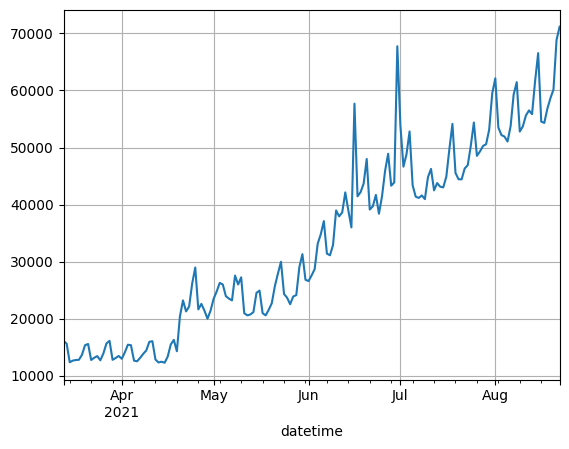

In [125]:
daily_inters.plot()
plt.grid();

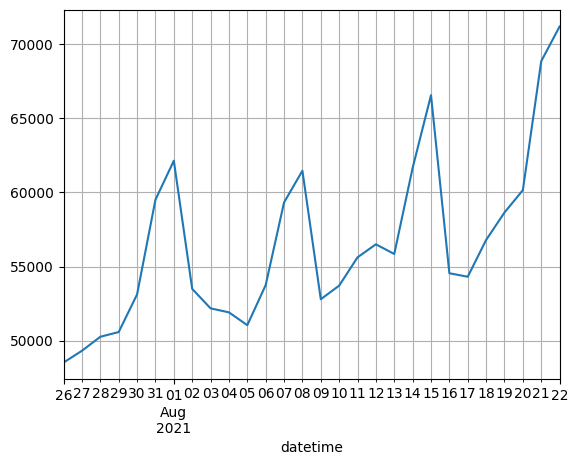

In [128]:
daily_inters[-28:].plot()
plt.grid(which='both');

In [129]:
pd.to_datetime('2021-08-01').weekday()

6

Trend is weekly. Lets define `pandas.date_range` with test fold will be the size of a week

In [103]:
n_folds = 3
unit = "D"
n_units = 7
# last_date = interactions[Columns.Datetime].max().normalize()
last_date = pd.to_datetime('15-08-2021', format='%d-%m-%Y')


start_date = last_date - pd.Timedelta(n_folds * n_units - 1, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"
print(f"""
    start_date: {start_date}
    last_date: {last_date}
    periods: {periods}
    freq: {freq}
""")

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
date_range


    start_date: 2021-07-26 00:00:00
    last_date: 2021-08-15 00:00:00
    periods: 4
    freq: 7D



DatetimeIndex(['2021-07-26', '2021-08-02', '2021-08-09', '2021-08-16'], dtype='datetime64[ns]', freq='7D')

In [105]:
inters = Interactions(interactions)

In [106]:
inters.df

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76.0,0.0
5476247,546862,9673,2021-04-13,2308.0,49.0
5476248,697262,15297,2021-08-20,18307.0,63.0
5476249,384202,16197,2021-04-19,6203.0,100.0


In [107]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
#     filter_cold_items=True,
#     filter_cold_users=True,
)
print(f"Real number of folds: {cv.get_n_splits(inters)}")

Real number of folds: 3


In [108]:
item_feat.feature.unique()

array(['genre', 'release_year'], dtype=object)

In [109]:
len(item_feat[item_feat.feature == 'release_year']['value'].unique())

11

In [110]:
user_features.feature.unique()

array(['age', 'sex', 'kids_flg', 'income'], dtype=object)

In [111]:
models = {
    'Popular': PopularModel(),
    'Popular_period=7d_pty=n_users': PopularModel(period=pd.Timedelta(7, unit='d'), popularity='n_users'),
    'Popular_period=7d_pty=n_interactions': PopularModel(period=pd.Timedelta(7, unit='d'), popularity='n_interactions'),
    'Popular_period=7d_pty=sum_weight': PopularModel(period=pd.Timedelta(7, unit='d'), popularity='sum_weight'),
    'Coverage_percentage=60': UsersCoverageModel(60.),
    'Coverage_percentage=80': UsersCoverageModel(80.),
    'Popular_categories_feature=genre_n=10': PopularInCategoryModel(category_feature='genre', n_categories=10),
    'Popular_categories_feature=release_year_n=10': PopularInCategoryModel(category_feature='release_year', n_categories=10),
    'Popular_categories_feature=release_year_n=3': PopularInCategoryModel(category_feature='release_year', n_categories=3),
    
}

K_RECOS = 10
metrics = {
    "Recall@10": Recall(k=K_RECOS),
    "MAP@10": MAP(k=K_RECOS),
}

In [112]:
fold_iterator = cv.split(inters)
results =[]

pbar = tqdm(enumerate(fold_iterator), total=cv.get_n_splits(inters))

for i_fold, (train_ids, test_ids, _) in pbar:     
    pbar.set_description(f'Fold#{i_fold}')
    
    df_train = inters.df.iloc[train_ids]
    item_feat_train = item_feat[item_feat[Columns.Item].isin(df_train[Columns.Item])]
    
    dataset = Dataset.construct(
        interactions_df=df_train,
        user_features_df=None,
        item_features_df=item_feat_train,
        cat_item_features=['genre', 'release_year']
    )

    df_test = inters.df.iloc[test_ids][Columns.UserItem]
    test_users = np.unique(df_test[Columns.User])
    
    for model_name, model in models.items():
        model = deepcopy(model)
        model.fit(dataset)
        recos = model.recommend(
            users=test_users,
            dataset=dataset,
            k=K_RECOS,
            filter_viewed=True,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train
        )
        res = {"fold": i_fold, "model": model_name}
        res.update(metric_values)
        results.append(res)

  0%|          | 0/3 [00:00<?, ?it/s]

n_users: 445353 (60.00%)


/Users/ml003/Documents/some_scripts/my_projects/mts_teta/ml/recom-homework/models/models.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  top_item = mode(matrix[~covered_users].indices)[0][0] # most frequent item among yet unchecked users


n_users: 593804 (80.00%)


/Users/ml003/Documents/some_scripts/my_projects/mts_teta/ml/recom-homework/models/models.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  top_item = mode(matrix[~covered_users].indices)[0][0] # most frequent item among yet unchecked users


n_users: 478453 (60.00%)


/Users/ml003/Documents/some_scripts/my_projects/mts_teta/ml/recom-homework/models/models.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  top_item = mode(matrix[~covered_users].indices)[0][0] # most frequent item among yet unchecked users


n_users: 637938 (80.00%)


/Users/ml003/Documents/some_scripts/my_projects/mts_teta/ml/recom-homework/models/models.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  top_item = mode(matrix[~covered_users].indices)[0][0] # most frequent item among yet unchecked users


n_users: 510293 (60.00%)


/Users/ml003/Documents/some_scripts/my_projects/mts_teta/ml/recom-homework/models/models.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  top_item = mode(matrix[~covered_users].indices)[0][0] # most frequent item among yet unchecked users


n_users: 680391 (80.00%)


/Users/ml003/Documents/some_scripts/my_projects/mts_teta/ml/recom-homework/models/models.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  top_item = mode(matrix[~covered_users].indices)[0][0] # most frequent item among yet unchecked users


In [113]:
df_results = pd.DataFrame(results)
df_results

,fold,model,Recall@10,MAP@10
0,0,Popular,0.190050,0.090403
1,0,Popular_period=7d_pty=n_users,0.218901,0.099084
2,0,Popular_period=7d_pty=n_interactions,0.218901,0.099084
3,0,Popular_period=7d_pty=sum_weight,0.171421,0.078639
4,0,Coverage_percentage=60,0.167902,0.071873
5,0,Coverage_percentage=80,0.167902,0.071873
6,0,Popular_categories_feature=genre_n=10,0.178986,0.078461
7,0,Popular_categories_feature=release_year_n=10,0.115974,0.059220
8,0,Popular_categories_feature=release_year_n=3,0.160597,0.067859
9,1,Popular,0.181957,0.089605


In [114]:
# Aggregate metrics by folds and compare models
pivot_results = pd.DataFrame(results).drop(columns='fold').groupby(['model'], sort=False).agg(['mean', 'std'])
pivot_results.round(5)

Recall@10            MAP@10  \
                                                  mean      std     mean   
model                                                                      
Popular                                        0.18148  0.00882  0.08754   
Popular_period=7d_pty=n_users                  0.21546  0.00831  0.09581   
Popular_period=7d_pty=n_interactions           0.21546  0.00831  0.09581   
Popular_period=7d_pty=sum_weight               0.15918  0.01196  0.07474   
Coverage_percentage=60                         0.16184  0.00831  0.07104   
Coverage_percentage=80                         0.16184  0.00831  0.07104   
Popular_categories_feature=genre_n=10          0.17579  0.00314  0.07657   
Popular_categories_feature=release_year_n=10   0.11562  0.00611  0.05966   
Popular_categories_feature=release_year_n=3    0.16117  0.00300  0.06811   

                                                       
                                                  std  
model                                                  
Popular                                       0.00429  
Popular_period=7d_pty=n_users                 0.00468  
Popular_period=7d_pty=n_interactions          0.00468  
Popular_period=7d_pty=sum_weight              0.00652  
Coverage_percentage=60                        0.00371  
Coverage_percentage=80                        0.00371  
Popular_categories_feature=genre_n=10         0.00179  
Popular_categories_feature=release_year_n=10  0.00382  
Popular_categories_feature=release_year_n=3   0.00314

In [115]:
pivot_results.round(5).sort_values(by=[('MAP@10', 'mean'), ('Recall@10', 'mean')], ascending=False)

Recall@10            MAP@10  \
                                                  mean      std     mean   
model                                                                      
Popular_period=7d_pty=n_users                  0.21546  0.00831  0.09581   
Popular_period=7d_pty=n_interactions           0.21546  0.00831  0.09581   
Popular                                        0.18148  0.00882  0.08754   
Popular_categories_feature=genre_n=10          0.17579  0.00314  0.07657   
Popular_period=7d_pty=sum_weight               0.15918  0.01196  0.07474   
Coverage_percentage=60                         0.16184  0.00831  0.07104   
Coverage_percentage=80                         0.16184  0.00831  0.07104   
Popular_categories_feature=release_year_n=3    0.16117  0.00300  0.06811   
Popular_categories_feature=release_year_n=10   0.11562  0.00611  0.05966   

                                                       
                                                  std  
model                                                  
Popular_period=7d_pty=n_users                 0.00468  
Popular_period=7d_pty=n_interactions          0.00468  
Popular                                       0.00429  
Popular_categories_feature=genre_n=10         0.00179  
Popular_period=7d_pty=sum_weight              0.00652  
Coverage_percentage=60                        0.00371  
Coverage_percentage=80                        0.00371  
Popular_categories_feature=release_year_n=3   0.00314  
Popular_categories_feature=release_year_n=10  0.00382